In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root
from scipy.integrate import odeint
%matplotlib inline

# Cosmological History 

__Question 1__ 

In this question we are attempting to solve for the early Universe during the radiation-dominated era after inflation. Since solving this directly requires many processes that we will not get into, we will use many rough estimates and approximations for our solution. We are mainly solving for the relativisitic degrees of freedom for various temperature thresholds and the transitions. 

Part IV 

Here we model a continuous transition in $g_*$ and $g_{*S}$ from $g_{high}$ to $g_{low}$, $g_{low,S}$ across a temperature threshold $T_0$ by arctan functions.

In [3]:
def g_star_f(T, g_low, g_high, T0, T_width):
    return g_low + (g_high - g_low) * (np.arctan((T - T0)/T_width) + (np.pi/2)) / np.pi

def g_starS_f(T, g_lowS, g_high, T0, T_width): # g*s
    return g_lowS + (g_high - g_lowS) * (np.arctan((T - T0)/T_width) + (np.pi/2)) / np.pi

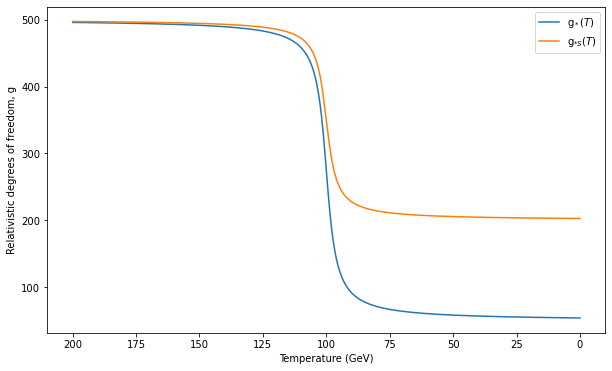

In [4]:
T_rh = 1e5 # GeV
g_high = 500
g_low = 50
g_lowS = 200
T0 = 100 # GeV
T_width = 3 # GeV
M_pl = 2.4e18 # GeV
t_rh = g_high**(-2/3) * T_rh**(-2)

T = np.arange(0, 200, 0.01) # GeV

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(T, g_star_f(T, g_low, g_high, T0, T_width), label="g$_*(T)$")
ax.plot(T, g_starS_f(T, g_lowS, g_high, T0, T_width), label="g$_{*S}(T)$")
ax.set_xlabel("Temperature (GeV)")
ax.set_ylabel("Relativistic degrees of freedom, g")
ax.invert_xaxis()
ax.legend()

* From the above we see that at high temperatures (earlier in time) $g_*$ and $g_{*s}$ have really similar values. As the temperature decreases, i.e after some cooling past $T_0$, the values are more split. 

The function that we use for this code is 

$$
g_{*S} = g_{low,S} + \frac{g_{high} - g_{low,S}}{\pi} \left[ arctan\left(\frac{T - T_0}{T_{width}} \right) + \frac{\pi}{2}\right]
$$

and

$$
g_{*S}(T) T^3 a^3 = g_{*S}(T_{rh})T_{rh}^3 = x \\
\rightarrow g_{*S}(T) T^3 a^3 - x = 0
$$

In [5]:
def Temp(a, g_high, g_starS, T_rh):
    T = (g_high/g_starS)**(1/3) * T_rh / a
    return T

def T_approx(a, g_high, g_lowS, T_rh, T0):
    T_above = T_rh / a
    T_below = T_rh * (g_high/g_lowS)**(1/3) / a
    T = []
    for i in range(len(a)):
        if T_above[i] >= T0:
            T.append(T_above[i])
        else:
            T.append(T_below[i])
    return np.array(T)

In [6]:
def equation(T, a):
    T_rh = 1e5 # GeV
    g_high = 500
    g_lowS = 200
    T0 = 100 # GeV
    T_width = 3 # GeV
    
    g_starS = g_lowS + (g_high - g_lowS) * (np.arctan((T - T0)/T_width) + (np.pi/2)) / np.pi
    rh = g_high * T_rh**3
    
    return g_starS * T**3 * a**3 - rh # T(a)

a = 10**(np.arange(0, 7, 0.01))
T_guess = Temp(a, g_high, 500, T_rh)
output = fsolve(equation, T_guess, a)
piece_wise = T_approx(a, g_high, g_lowS, T_rh, T0)

The ratio for numerical solution/piece wise approximation at a=10^7 is 0.9952712019108396


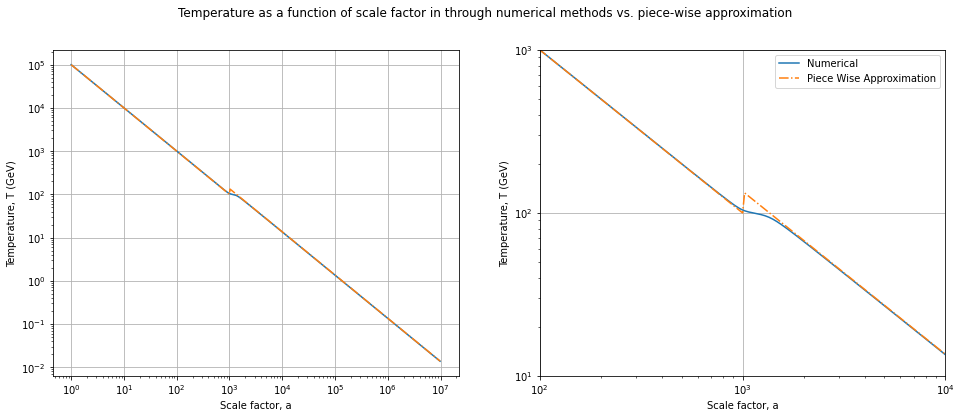

In [7]:
print("The ratio for numerical solution/piece wise approximation at a=10^7 is", output[-1]/piece_wise[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle("Temperature as a function of scale factor in through numerical methods vs. piece-wise approximation")

ax[0].loglog(a, output, label="Numerical")
ax[0].plot(a, piece_wise,'-.', label="Piece Wise Approximation")
ax[0].set_xlabel("Scale factor, a")
ax[0].set_ylabel("Temperature, T (GeV)")
ax[0].grid()

ax[1].loglog(a, output, label="Numerical")
ax[1].plot(a, piece_wise,'-.', label="Piece Wise Approximation")
ax[1].set_xlabel("Scale factor, a")
ax[1].set_ylabel("Temperature, T (GeV)")
ax[1].set_xlim(1e2, 1e4)
ax[1].set_ylim(1e1, 1e3)
ax[1].legend()
ax[1].grid()

At $T = T_0$, this is when electron-positron annihilation happens. During this process, the energy created keeps the photon bath from cooling down as fast, as a result we see a delay in the temperature drop as a function of the scale factor. 

__Part V__

In this section we solve the FRW equations assuming radiation dominated and using our numerical solution for the function $T(a)$ above. From lecture we solved for the FRW equation as 

$$
H^2 = \left(\frac{\dot{a}}{a}\right)^2 = \frac{\pi^2}{90 M_{pl}^2} g_*(T) T^4 \\
\rightarrow \frac{\dot{a}}{a} = \frac{\pi}{\sqrt{90}} \frac{g_*(T)^\frac{1}{2}}{M_{pl}} T^2
$$

In [8]:
# Numerical solution 
t = 10**(np.linspace(0, 12, len(a)))

def FRW_eq(a, t):
    temp = fsolve(equation, 1, args=a)
    g_starS = g_star_f(temp, g_low, g_high, T0, T_width)
    return np.pi * g_starS * temp**2 * a / (np.sqrt(90) * M_pl)

# Analytical approximation of a(t)
def a_approx(t, g_high, g_low, g_lowS, t_rh, t0):
    t_above = (t/t_rh)**(1/2)
    t_below = g_high**(1/2) * g_low**(1/4) * g_lowS**(-1/3) * (t/t_rh)**(1/2)
    a = []
    for i in range(len(t)):
        if t[i] <= t0:
            a.append(t_above[i])
        elif t[i] > t0:
            a.append(t_below[i])
    return np.array(a)

# Analytical approximation of T(t)
def T_temp_approx(t, g_high, g_low, t_rh, T_rh, t0):
    temp_above = T_rh * t_rh**(1/2) * t**(-1/2)
    temp_below = T_rh * t_rh**(1/2) * (g_high/g_low)**(1/4) * t**(-1/2)
    T = []
    for i in range(len(t)):
        if t[i] <= t0:
            T.append(temp_above[i])
        else:
            T.append(temp_below[i])
    return np.array(T)

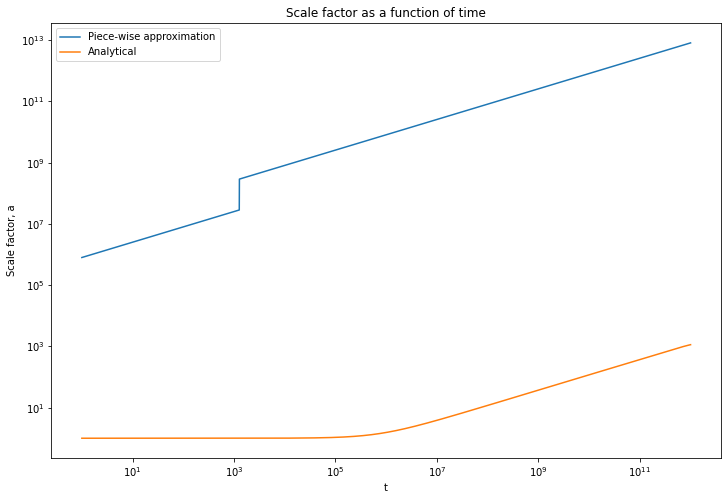

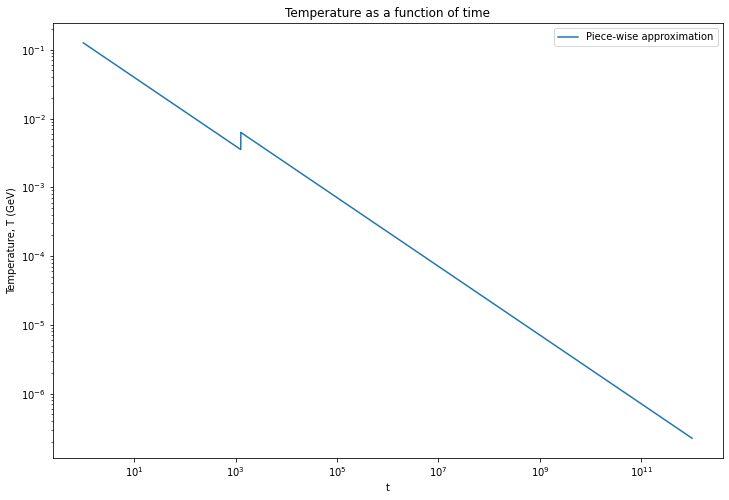

In [9]:
t_rh = g_high**(-2/3) * T_rh**(-2)
t0 = (g_high/g_starS_f(T0, g_lowS, g_high, T0, T_width))**(2/3) * (T_rh/T0)
t = 10**(np.arange(0, 12, 0.001))
a_new = odeint(FRW_eq, 1, t)

plt.figure(figsize=(12,8))
plt.loglog(t, a_approx(t, g_high, g_low, g_lowS, t_rh, t0), label="Piece-wise approximation")
plt.loglog(t, a_new, label="Analytical")
plt.title("Scale factor as a function of time")
plt.xlabel("t")
plt.ylabel("Scale factor, a")
plt.legend()

plt.figure(figsize=(12,8))
plt.loglog(t, T_temp_approx(t, g_high, g_low, t_rh, T_rh, t0), label="Piece-wise approximation")
plt.title("Temperature as a function of time")
plt.xlabel("t")
plt.ylabel("Temperature, T (GeV)")
plt.legend()

__b)__


Here we are constructing a piece-wise approximation of $g_{*}(T)$ and $g_{*S}(T)$ assuming that each particle type stops being relativistic once $T \lesssim m_i$. We are reconstructing the relativistic degrees of freedom following the equation 

$$
g_*(T) = \sum_{i = b} g_i + \sum_{i = f} \left( \frac{7}{8} \right) g_i
$$

Notice that we have completely neglected the decoupling terms in order to keep the degrees of freedom constant between threshold temperatures. 

__Note__: The $g$ value provided to us in the table for fermions already accounts for the $(7/8)$ factor.


In [10]:
T = 2*10**(np.arange(-5, 2, 0.01)) # GeV
#T = np.arange(0.00001, 200, 0.01) # GeV

def g_star_approx(T):
    
    # Decoupling temperatures (GeV)
    T_DM = 100 
    T_tquark = 30
    T_WZbosons = 15
    T_bquark = 1
    T_bundle = 0.2
    T_pions = 0.05 # pions and muons
    T_electron = 0.00025
    
    # Effective number of dof:
    
    # Bosons
    bosons = {'W':3*2, 'Z': 3, 'h': 1, 'photon': 2, 'gluons': 8*2, 'pion': 2, 'pion0': 1}
    
    # Fermions
    fermions = {'DM': 4,'tquark': (7/8) * 4*3, 'bquark': (7/8) * 4*3, 'cquark': (7/8) * 4*3, 'squark': (7/8) * 4*3,
            'uquark': (7/8) * 4*3, 'dquark': (7/8) * 4*3, 'tau': (7/8) * 4, 'muon': (7/8) * 4, 'electron': (7/8) * 4,
            'electron_neutrino': (7/8) * 2, 'muon_neutrino': (7/8) * 2, 'tau_neutrino': (7/8) * 2}
    
    g_star = []
    for i in range(len(T)):
        g_th = 0
        
        if T[i] >= T_DM: # all particles in bath 
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(fermions.values())
            
        elif T[i] >= T_tquark: # DM out of bath
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(dict(list(fermions.items())[1:]).values())
            
        elif T[i] >= T_WZbosons: # top quark out of bath
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(dict(list(fermions.items())[2:]).values())
            
        elif T[i] >= T_bquark: # W, Z, h bosons out of bath 
            g_th += sum(dict(list(bosons.items())[3:5]).values()) + sum(dict(list(fermions.items())[2:]).values())
            
        elif T[i] >= T_bundle: # bottom quark out of the bath
            g_th += sum(dict(list(bosons.items())[3:5]).values()) + sum(dict(list(fermions.items())[3:]).values())
        
        elif T[i] >= T_pions: # rest of the quarks, gluon, tau leave, but pions come into bath
            g_th += bosons['photon'] + sum(dict(list(bosons.items())[5:]).values()) + sum(dict(list(fermions.items())[8:]).values())
            
        elif T[i] >= T_electron: # pions and muons leave bath 
            g_th += bosons['photon'] + sum(dict(list(fermions.items())[9:]).values())
        
        else: # electrons leave bath
            g_th += bosons['photon'] + sum(dict(list(fermions.items())[10:]).values()) * (4/11)**(4/3)
        
        g_star.append(g_th)
    
    return np.array(g_star)
        
def g_starS_approx(T):
    
    # Decoupling temperatures (GeV)
    T_DM = 100 
    T_tquark = 30
    T_WZbosons = 15
    T_bquark = 1
    T_bundle = 0.2
    T_pions = 0.05 # pions and muons
    T_electron = 0.00025
    
    # Effective number of dof:
    
    # Bosons
    bosons = {'W':3*2, 'Z': 3, 'h': 1, 'photon': 2, 'gluons': 8*2, 'pion': 2, 'pion0': 1}
    
    # Fermions
    fermions = {'DM': 4,'tquark': (7/8) * 4*3, 'bquark': (7/8) * 4*3, 'cquark': (7/8) * 4*3, 'squark': (7/8) * 4*3,
            'uquark': (7/8) * 4*3, 'dquark': (7/8) * 4*3, 'tau': (7/8) * 4, 'muon': (7/8) * 4, 'electron': (7/8) * 4,
            'electron_neutrino': (7/8) * 2, 'muon_neutrino': (7/8) * 2, 'tau_neutrino': (7/8) * 2}
    
    g_star = []
    for i in range(len(T)):
        g_th = 0
        
        if T[i] >= T_DM: # all particles in bath 
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(fermions.values())
            
        elif T[i] >= T_tquark: # DM out of bath
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(dict(list(fermions.items())[1:]).values())
            
        elif T[i] >= T_WZbosons: # top quark out of bath
            g_th += sum(dict(list(bosons.items())[:5]).values()) + sum(dict(list(fermions.items())[2:]).values())
            
        elif T[i] >= T_bquark: # W, Z, h bosons out of bath 
            g_th += sum(dict(list(bosons.items())[3:5]).values()) + sum(dict(list(fermions.items())[2:]).values())
            
        elif T[i] >= T_bundle: # bottom quark out of the bath
            g_th += sum(dict(list(bosons.items())[3:5]).values()) + sum(dict(list(fermions.items())[3:]).values())
        
        elif T[i] >= T_pions: # rest of the quarks, gluon, tau leave, but pions come into bath
            g_th += bosons['photon'] + sum(dict(list(bosons.items())[5:]).values()) + sum(dict(list(fermions.items())[8:]).values())
            
        elif T[i] >= T_electron: # pions and muons leave bath 
            g_th += bosons['photon'] + sum(dict(list(fermions.items())[9:]).values())
        
        else: # electrons leave bath
            g_th += bosons['photon'] + sum(dict(list(fermions.items())[10:]).values()) * (4/11)
        
        g_star.append(g_th)
    
    return np.array(g_star)


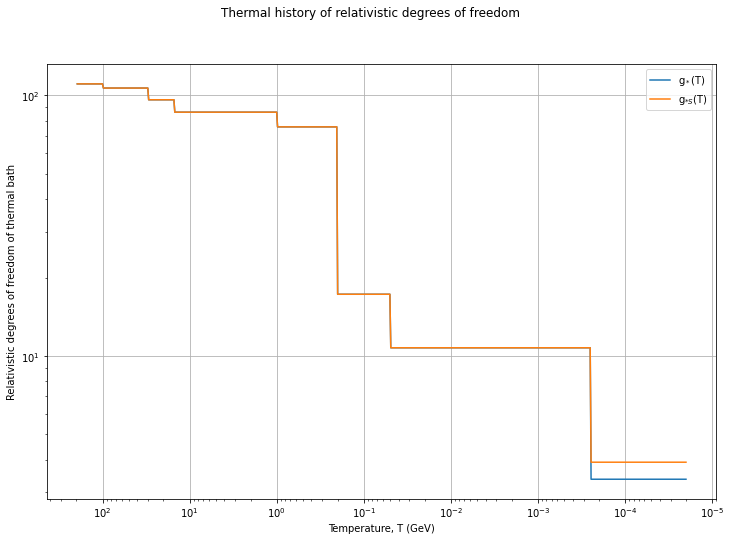

In [11]:
new_g_star = g_star_approx(T)
new_g_starS = g_starS_approx(T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
fig.suptitle("Thermal history of relativistic degrees of freedom")
ax.loglog(T, new_g_star, label="g$_*$(T)")
ax.plot(T, new_g_starS, label="g$_{*S}$(T)")
ax.set_xlabel("Temperature, T (GeV)")
ax.set_ylabel("Relativistic degrees of freedom of thermal bath")
ax.invert_xaxis()
ax.grid()
ax.legend()

In [12]:
T_print = [200, 50, 20, 10, 0.5, 0.1, 0.01, 0.0001] # GeV
T_threshold = [100, 30, 15, 1, 0.2, 0.05, 0.00025] # GeV
g_star_table = {'T_print': T_print, 'g*(T)': list(g_star_approx(T_print)), 'g*S(T)': list(g_starS_approx(T_print))}
g_star_table

{'T_print': [200, 50, 20, 10, 0.5, 0.1, 0.01, 0.0001],
 'g*(T)': [110.75,
  106.75,
  96.25,
  86.25,
  75.75,
  17.25,
  10.75,
  3.362643905961434],
 'g*S(T)': [110.75,
  106.75,
  96.25,
  86.25,
  75.75,
  17.25,
  10.75,
  3.909090909090909]}

__c)__

Using the piece-wise approximations for $T(a)$ and $a(t)$ we derived earlier, we can adapt this for our current situation with multiple thresholds. This is what we do below.

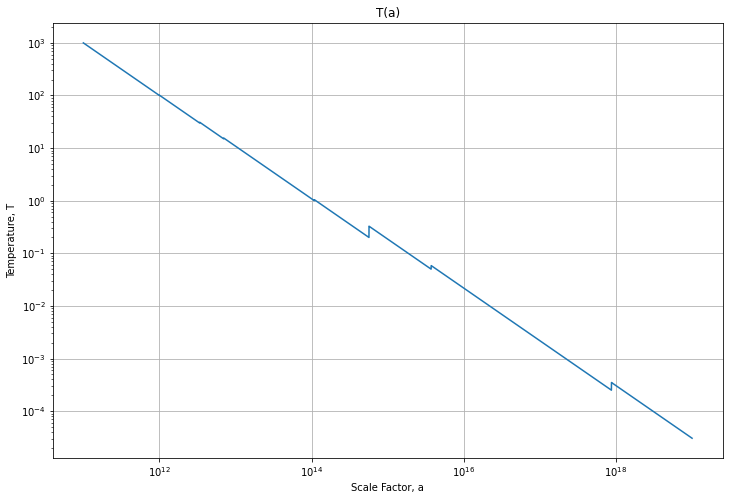

In [13]:
new_T_rh = 10**(14) # GeV
new_a = 10**(np.arange(11, 19, 0.001))

def new_T_approx(a, T_rh, t_rh, g_star_table: dict, threshold_table: list):
    T_above = T_rh / a # Calculate T_above based on T_rh
    T = T_above # T starts as T_above 
    g_high = g_star_table['g*(T)'][0] # g_high is always first value 
    
    # we find the time points for a(t) as well for each time we cross the thresholds 
    t_trh = []
    t_threshold = []
    new_g_star_table = g_star_table
    new_g_star_table['g_low(T)'] = [g_star_table['g*(T)'][0]]
    
    # Subsequently change T 
    for k in range(len(threshold_table)): # Loop over all 7 threshold values
        T0 = threshold_table[k] # Set threshold as T0
        g_lowS = g_star_table['g*S(T)'][k+1] # g_lowS starts as the value after threshold
        T_below = T_rh * (g_high/g_lowS)**(1/3) / a # Calculate T_below
        
        # For a(t)
        t_threshold.append(t_rh*(g_high/g_lowS)**(2/3) * (T_rh/T0)**2) # For noting down the threshold time
        #if k > 0:
        new_g_star_table['g_low(T)'].append(g_star_table['g*(T)'][k+1])
            #new_g_star_table['g_low(T)'].append(g_star_table['g*(T)'][k])
        
        for i in range(len(T)): # Whenever temperature drops below threshold, change values from there on to T_below
            if T[i] < T0: 
                T[i] = T_below[i]
            
            # For a(t)
            if k == 0:
                t_trh.append(t_rh*(g_high/g_lowS)**(2/3) * (T_rh/T[i])**2)

    return T, t_trh, t_threshold, new_g_star_table

new_temp = new_T_approx(new_a, new_T_rh, t_rh, g_star_table, T_threshold)
plt.figure(figsize=(12,8))
plt.loglog(new_a, new_temp[0])
plt.title("T(a)")
plt.xlabel("Scale Factor, a")
plt.ylabel("Temperature, T")
plt.grid()

In [14]:
t_threshold = new_temp[2]
new_g_star_table = new_temp[3]

def a_function(t, t_rh, t_threshold: list, new_g_star_table: dict):
    a_high = (t_rh)**(-1/2) * t**(1/2)
    a = a_high
    g_high = new_g_star_table['g*(T)'][0]
    
    for i in range(len(t_threshold)):
        g_low = new_g_star_table['g_low(T)'][i]
        g_lowS = new_g_star_table['g*S(T)'][i]
        
        a_low = (t/t_rh)**(1/2) * g_high**(1/12) * g_low**(1/4) * g_lowS**(-1/3)
        
        for j in range(len(t)):
            if t[j] > t_threshold[i]:
                a[j] = a_low[j]    
    return a

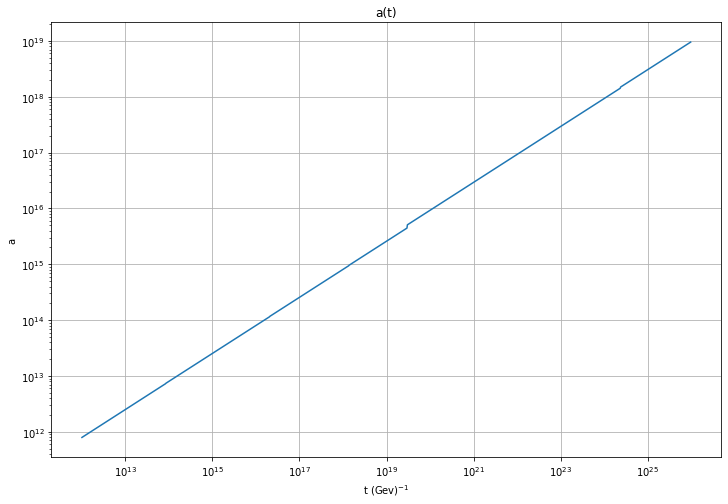

In [15]:
#t = np.array(new_temp[1])
t = 10**(np.arange(12, 26, 0.01))
t_threshold = new_temp[2]
new_g_star_table = new_temp[3]
a = a_function(t, t_rh, t_threshold, new_g_star_table)

plt.figure(figsize=(12,8))
plt.loglog(t, a)
plt.title("a(t)")
plt.xlabel("t (Gev)$^{-1}$")
plt.ylabel("a")
plt.grid()

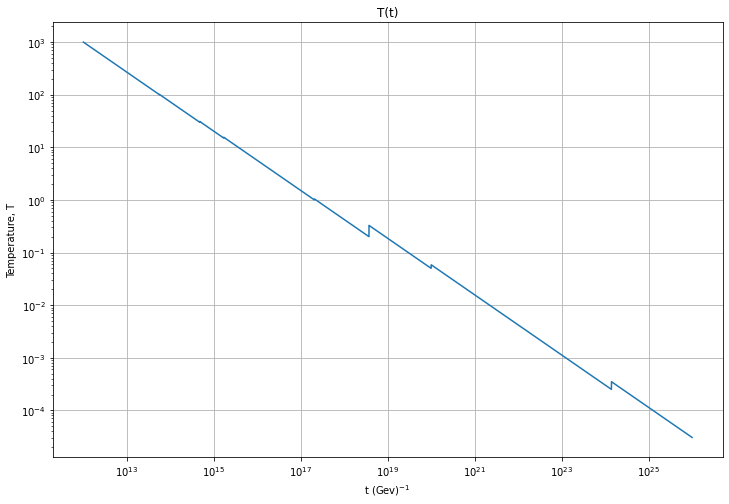

In [16]:
t = 10**(np.linspace(12, 26, len(new_temp[0])))

plt.figure(figsize=(12,8))
plt.loglog(t, new_temp[0])
plt.xlabel("t (Gev)$^{-1}$")
plt.ylabel("Temperature, T")
plt.title("T(t)")
plt.grid()

__e)__

In [17]:
M_x = 500
M_pl = 2.4e18
T0 = 0.24e-12 
g_T0 = 3.91
H0 = 1.58e-42
omega_x = 0.27

g_w = ( ((2*(np.pi**2)*M_x)/(3*45*(M_pl**2))) * (g_T0*(T0**3)/H0**2) * (6e-17/omega_x) )**(1/3.8)
g_w

0.0778049416117901

__f)__

In [18]:
g_Trh = 110.75
g_Tr = 3.91
T_rh = 1e14
T = 0.0002
a_r = (g_Trh/g_Tr)**(1/3) * (T_rh/T)
a_r

1.5241428163903777e+18

In [19]:
rho_crit = (3*(H0**2) * (M_pl**2)) * (a_r)**(-4)
rho_crit

7.993836440439052e-120

In [20]:
rho_r = np.pi**2 * 3.36 * T**4 / 30
rho_r

1.7686331086752132e-15

In [21]:
rho_r/rho_crit

2.2124959921972996e+104